In [1]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_csv('../data/daily-total-female-births.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
# Set the date as index 
df = df.set_index('Date')
# Select the proper time period for weekly aggreagation -- changed to M monthly , W to weekly
df = df['1959-01-04':'1959-11-30'].resample('M').sum()

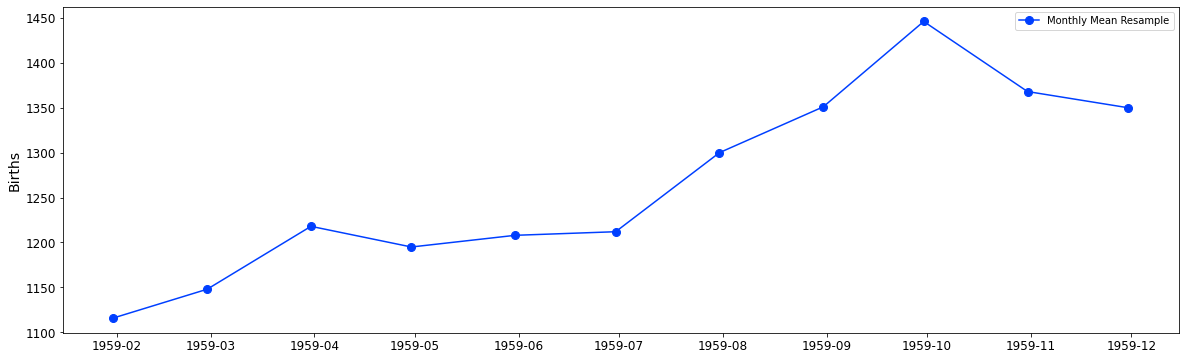

In [4]:
y = df['Births']
fig, ax = plt.subplots(figsize=(20, 6))
#ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Births')
ax.legend();

In [5]:
y_to_train = y[:'1959-01-31'] # dataset to train
y_to_val = y['1959-12-30':] # last X months for test  
predict_date = len(y) - len(y[:'1959-12-30']) # the number of data points for the test set

In [6]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [7]:
sarima_grid_search(y,6)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79629D+00    |proj g|=  1.62041D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   2.805D-07   7.796D+00
  F =   7.7961800836108770     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.0

In [8]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    

    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.577e+04   1.07e+05      0.334      0.739   -1.74e+05    2.46e+05
The Root Mean Squared Error of SARIMA with season_length=6 and dynamic = False nan


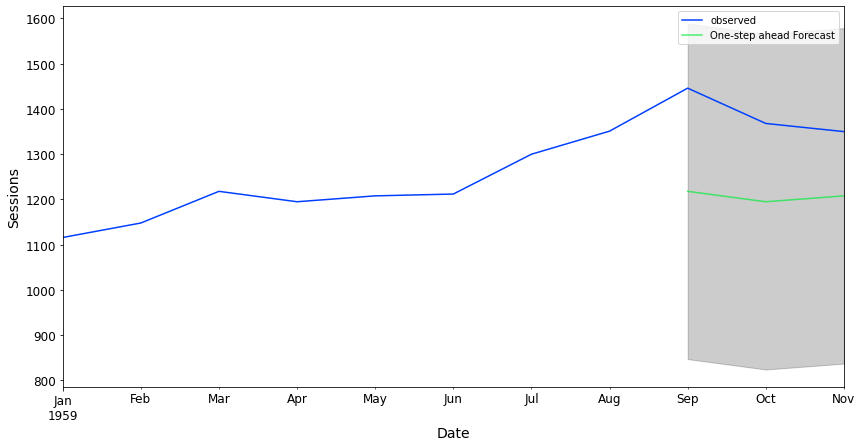

The Root Mean Squared Error of SARIMA with season_length=6 and dynamic = True nan


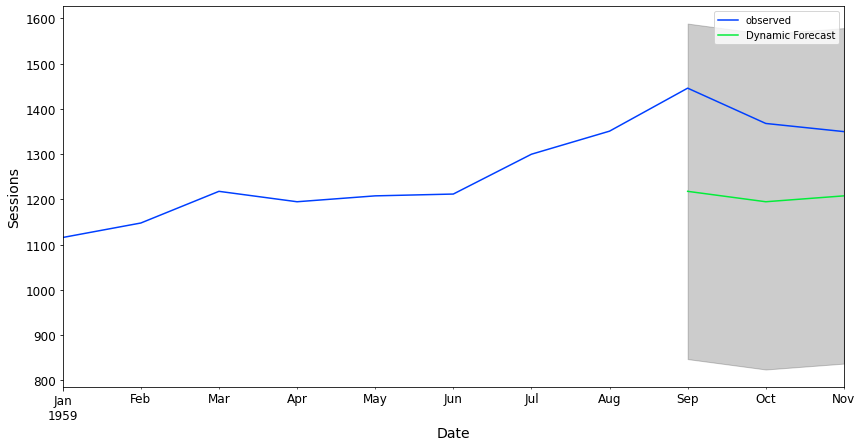

In [9]:
model = sarima_eva(y,(0, 0, 0),(0, 1, 0, 6),6,'1959-09-30' ,y_to_val)

In [21]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='r')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

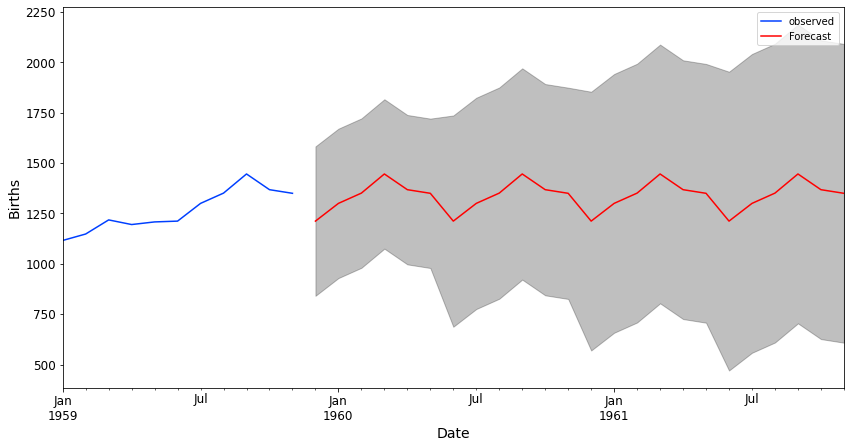

In [22]:
final_table = forecast(model,24,y)
#final_table.head()

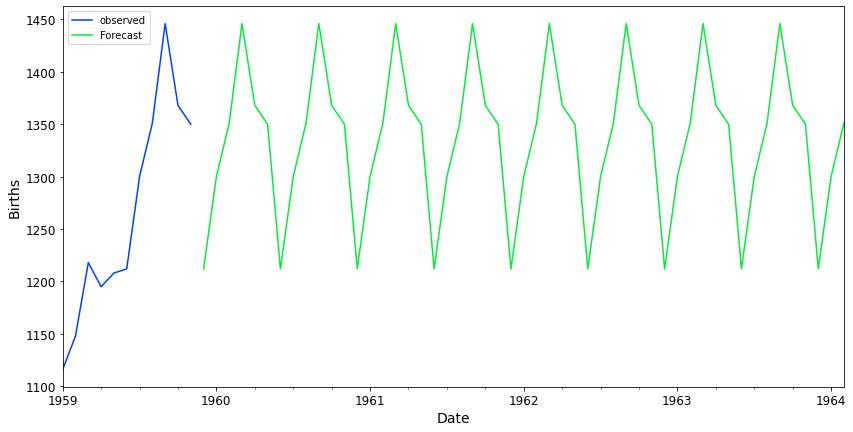

In [20]:
### Graphs without the confident interval 
# arma_df = model.predict(start='2020-01-01', end='2023-12-01')
pred_uc = model.get_forecast(steps=51)
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()